In [1]:
import numpy as np
import pandas as pd

from heston_pricer import SINC_discFT, BSImpliedVol

from scipy.optimize import minimize

import keras
from keras.layers import Activation
from keras import backend as K
keras.backend.set_floatx('float64')
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

<h3> auxiliary function for cHeston FT-calibration to the market

In [2]:
def fn(params, mkt_vol, maturities, strikes):

    S0 = 1
    IR = 0
    DY = 0
    
    CP = 1
    
    N = (1 << 12)

    Xc = 40 * np.sqrt(T)
    
    N_maturities = len(maturities)

    mdl_vol = []
    for i in range(N_maturities):
        T_tmp = maturities[i]
        K_tmp = strikes[i]
        call = SINC_discFT(S0, T_tmp ,K_tmp , IR, DY, params, Xc[i], N, CP)
        ivol = BSImpliedVol(S0, K_tmp, T_tmp, IR, call, CP)
        mdl_vol.extend(ivol)
        
    err = np.abs(np.concatenate(mkt_vol) - np.array(mdl_vol))
    mse = np.sum(err**2)
    
    return mse

<h3> import market data

In [3]:
spot = 1

mktData = pd.read_csv('SPXEOD20140916.csv')

T = mktData["time2maturity"].values
K = (mktData["strike"]/mktData["forward"]).values
bid_vol = mktData["bid_vol"].values
ask_vol = mktData["ask_vol"].values
imp_vol = 0.5*(bid_vol+ask_vol)

maturities = pd.unique(T)
BID = [bid_vol[T==t] for t in maturities]
ASK = [ask_vol[T==t] for t in maturities]
mkt_vol = [imp_vol[T==t] for t in maturities]
strikes = [K[T==t] for t in maturities]

<h3> cHeston FT-calibration

In [4]:
obj = lambda params: fn(params, mkt_vol, maturities, strikes)

lb = [2.00, 0.01, 1.00, 0.01, -0.90]
ub = [9.00, 0.20, 4.00, 0.20, -0.50]

init_par = 0.5 * (np.array(lb) + np.array(ub))

options = {'disp': True, 'maxiter': 5000, 'ftol': 1e-6}

res = minimize(obj, init_par, method='L-BFGS-B', bounds=list(zip(lb, ub)), options=options)

optm_params = res.x

print('optm params: ' + str(optm_params))
fval = res.fun
print('fval: ' + str(fval))

optm params: [ 5.86238328  0.03894898  1.58077205  0.01127874 -0.71623068]
fval: 0.115917377176018


<h3> pricing with cHeston optimal parameters

In [5]:
N_maturities = len(maturities)

mdl_vol_cHes = []
for i in range(N_maturities):
    T_tmp = maturities[i]
    K_tmp = strikes[i]
    call = SINC_discFT(spot, T_tmp ,K_tmp , 0, 0, optm_params, 40*np.sqrt(T[i]), 1<<12, 1)
    ivol = BSImpliedVol(spot, K_tmp, T_tmp, 0, call, 1)
    mdl_vol_cHes.append(ivol)

<h3> preparing for NN-calibration with the rHeston model

In [6]:
N_strikes = 13
N_times = 11

N_params_fvc = 8
N_params_mdl = 3

N_params = N_params_fvc + N_params_mdl

>    set up the network

In [7]:
N_hiddenLayers = 4
N_nodes = 64
i = keras.layers.Input(shape=(N_params+1+1, ))
x = keras.layers.Dense(N_nodes, activation='elu')(i)
c = 0
while c < N_hiddenLayers:
    x = keras.layers.Dense(N_nodes, activation='elu')(x)
    c += 1
x = keras.layers.Dense(1, activation='linear')(x)

model = keras.models.Model(inputs=i, outputs=x)

>    load NN weights

In [8]:
model.load_weights('rHestonNNWeights.h5')

NNWeights = []
for i in range(1, len(model.layers)):
    NNWeights.append(model.layers[i].get_weights())

>    hardcode the NN in numpy

In [9]:
N_layers = N_hiddenLayers + 1

def elu(x):
    ind = (x<0)
    x[ind] = np.exp(x[ind])-1
    return x

def eluPrime(x):
    y = np.copy(x)
    ind = (y<0)
    y[ind] = np.exp(y[ind])
    y[~ind] = 1
    return y

def NNFun(params, T, K):
    N = len(T)
    PARAMS = np.array(N*[params])
    input1 = np.c_[PARAMS, T, K] 
    for i in range(N_layers):
        input1 = np.dot(input1, NNWeights[i][0]) + NNWeights[i][1]
        input1 = elu(input1)
    i += 1
    X = np.dot(input1, NNWeights[i][0]) + NNWeights[i][1]
    X = [el[0] for el in X]
    X = np.array(X)
    return X

def NNGrad(params, T, K):
    N = len(T)
    PARAMS = np.array(N*[params])
    input1 = np.c_[PARAMS, T, K] 
    # k = 0
    input1 = np.dot(input1, NNWeights[0][0]) + NNWeights[0][1]
    grad = np.ndarray(shape=(N, N_params+1+1, N_nodes))
    for j in range(N):
        grad[j] = NNWeights[0][0]
    eP = eluPrime(input1)
    grad *= eP[:, None, :]
    input1 = elu(input1)
    #
    for k in range(1,N_layers):
        input1 = np.dot(input1, NNWeights[k][0])
        input1 += NNWeights[k][1]
        for n in range(N):
            grad[n] = np.dot(grad[n], NNWeights[k][0])
        eP = eluPrime(input1)
        grad *= eP[:, None, :]
        input1 = elu(input1)
    grad = np.dot(grad, NNWeights[k+1][0])
    grad = grad[:,:N_params].reshape(N, N_params).T
    return grad

<h3> rHeston NN-calibration

>    write the cost function

In [10]:
def CostFunc(params, T, K, target):
    return np.sum(np.power((NNFun(params, T, K)-target), 2))
def Jacobian(params, T, K, target):
    return 2*np.sum((NNFun(params, T, K)-target)*NNGrad(params, T, K), axis=1)

>    bounds and initial guess

In [11]:
bounds = ([0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.010, 0.150, -.950], 
          [0.160, 0.160, 0.160, 0.160, 0.160, 0.160, 0.160, 0.160, 0.250, 0.650, -.500])
bounds = [(lower, upper) for lower, upper in zip(*bounds)]

init = []
for bound in bounds:
    init.append(0.5*(bound[0]+bound[1]))

>    minimization

In [12]:
res = minimize(lambda x: CostFunc(x, T, K, imp_vol), x0=init, 
               method='L-BFGS-B', jac=lambda x: Jacobian(x, T, K, imp_vol), bounds=bounds, 
               tol=1E-10, options={"maxiter":5000})

optm_params = res.x
print('optm params: ' + str(optm_params))
fval = res.fun
print('fval: ' + str(fval))

optm params: [ 0.01887786  0.02262434  0.01457648  0.02425499  0.03314759  0.04013041
  0.04310426  0.05533438  0.02323979  0.27597475 -0.70732594]
fval: 0.020809130167196033


>    pricing with the optimal parameters

In [13]:
ivol_NN = NNFun(optm_params, T, K)

In [14]:
mdl_vol_rHes = []
for i in range(N_maturities):
    mask = len(T)*[False]
    for j in range(len(T)):
        if T[j]==maturities[i]:
            mask[j] = True
    mdl_vol_rHes.append(ivol_NN[mask].tolist())

>    show the fit

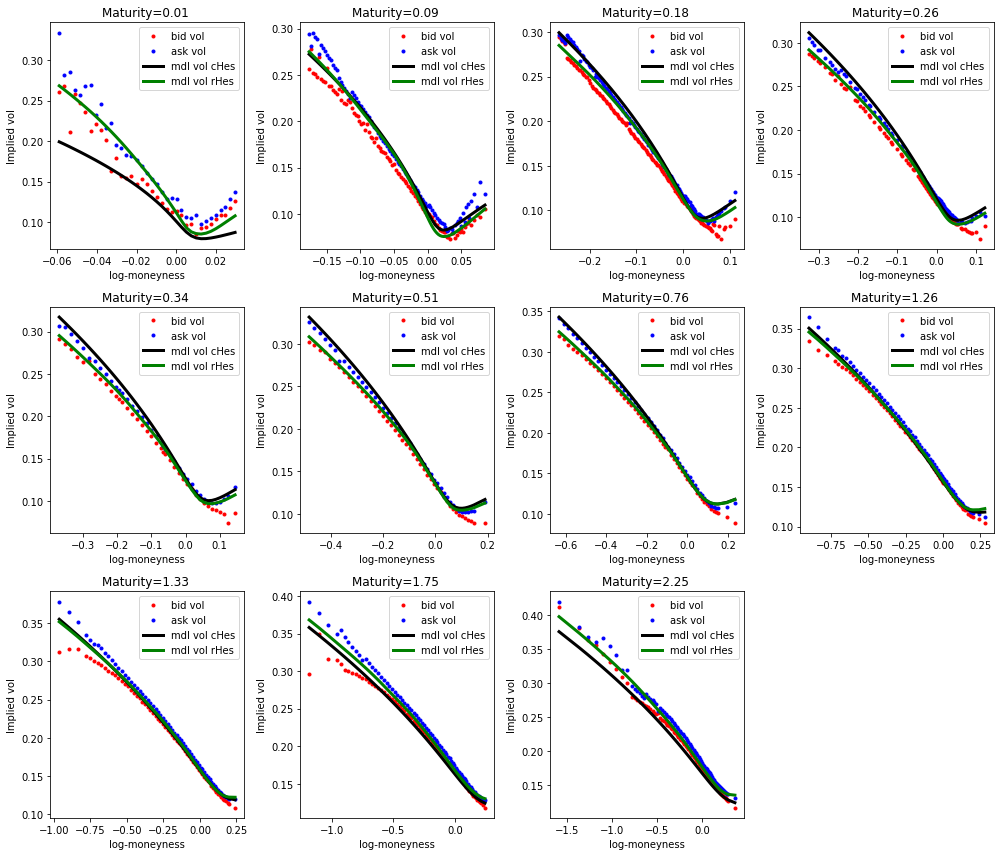

In [15]:
plt.figure(1, figsize=(14,12))
for i in range(N_maturities):
    plt.subplot(int(np.floor(N_maturities/4)+1), 4, i+1)
    
    plt.plot(np.log(strikes[i]/spot), BID[i], 'r.'  , label="bid vol")
    plt.plot(np.log(strikes[i]/spot), ASK[i], 'b.'  , label="ask vol")
    plt.plot(np.log(strikes[i]/spot), mdl_vol_cHes[i], 'k', linewidth=3, label="mdl vol cHes")
    plt.plot(np.log(strikes[i]/spot), mdl_vol_rHes[i], 'g', linewidth=3, label="mdl vol rHes")
    
    plt.title("Maturity=%1.2f "%np.unique(maturities)[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()